In [165]:
# Import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [166]:
class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.acceleration = np.zeros(3)
    
    def update_position(self, dt, grid_size):
        """Update particles position based on velocity"""
        self.position += self.velocity * dt
        collision, collision_velocities = self.check_wall_collision(self.position, grid_size)
            
        return collision, collision_velocities, self.position
        
    def check_wall_collision(self, particle, grid_size =None):
        """Check for collisons if box size is given"""
        if grid_size is not None:
            
            #Implement collison dectectation
            collision = False
            
            # Convert grid_size to float to ensure consistent arithmetic
            L = float(grid_size)
            
            # Initialize collision velocities for all directions as None
            collision_velocities = {'x': [], 'y': [], 'z': []}

            #Checks for collision with each wall
            for i in range(3):
                if self.position[i] < -L/2 or self.position[i] > L/2:
                    collision = True  
                    # Record the velocity before the collision for the appropriate direction
                    if i == 0:  # x-direction
                        collision_velocities['x'].append(self.velocity[i])
                    elif i == 1:  # y-direction
                        collision_velocities['y'].append(self.velocity[i])
                    elif i == 2:  # z-direction
                        collision_velocities['z'].append(self.velocity[i])
                  
                    # Reflect the particle's velocity
                    self.velocity[i] *= -1
                
                    # Correct position if particle is beyond the wall
                    self.position[i] = np.clip(self.position[i], -L/2, L/2)
                    
            return collision, collision_velocities
            
    def update_velocity(self, dt):
        """Update particles velocity with acceleration"""
        self.velocity += (dt/2) * self.acceleration
        return self.velocity

    def update_acceleration(self, net_force):
        """Update of all particles acceleration based on net force"""
        self.acceleration = net_force
        return self.acceleration
    

In [167]:
class Force:
    def __init__(self, particle_i, particle_j):
        self.particle_i = particle_i
        self.particle_j = particle_j
    
    def lj_potential(self, particles):
        """Calculate Lennard-Jones potential between all pairs of atoms"""
        potential_energy = []
        for particle_j in particles:
            if particle_j == self.particle_i:
                continue
            r = (particle_j.position - self.particle_i.position) 
            r_norm = np.linalg.norm(r)
            if r_norm == 0:
                continue #Handles division by 0
            v_lj = 4 * ( (1/r)**12 - (1/r)**6)
            potential_energy.append(v_lj)
        return potential_energy
    
    def net_force(self, particles):
        """Calculate net force from i to j"""
        net_force = 0
        
        #Iterates over all particles in the system
        for particle_j in particles:
            if particle_j == self.particle_i: 
                #Skips particle_i
                continue
            
            #Calculate the force atom j exerts on atom i 
            r = (particle_j.position - self.particle_i.position) 
            r_norm = np.linalg.norm(r)
            if r_norm == 0:
                continue #Handles division by 0
            force_ij = 24*((-2*((1/r_norm)**13)) + (1/r_norm)**7) * (r/r_norm)
            
            #Calculating net force on current particle by other particles
            net_force += force_ij
        return net_force    
    

In [169]:
class Simulation:
    def __init__(self, num_particles, grid_size, dt, custom_positions =None, custom_velocities =None):
        self.N = num_particles
        self.L = grid_size
        self.dt = dt
        self.particles = self.initialize_particles(custom_positions, custom_velocities)

    def initialize_particles(self, custom_positions = None, custom_velocities=None):
        """Initialize particles with random positions or custom positions if provided"""
        particles = []
        
        if custom_positions:
            
            #if custom_positions are provided, use them given they match criteria below
            if len(custom_positions) != self.N:
                
                #Checks if len of custom positions matches
                raise ValueError(" Number of custom positions must match number of particles")
            
            if custom_velocities and len(custom_velocities) != N:
                raise ValueError("Number of custom velocities must match number of particles")
            
            #Check if pos' lies within grid 
            for i, pos in enumerate(custom_positions):
                
                if not all(-self.L/2 <= p <= self.L/2 for p in pos):
                    raise ValueError("Custom position must be within the grid bounds")
                
                if custom_velocities:
                    velocity = custom_velocities[i]
                else:
                    # Initialize velocities as zero if no custom velocities
                    velocity = np.zeros(3)
                    
            #If criteria above is met initalize
                #Instantaition of Particle class
                particle = Particle(pos, velocity)
                #Adding particle to particle list
                particles.append(particle)
                
            return particles      
        else:
            for atom in range(self.N):
                # Initialize particles with random positions and velocities
                position = np.random.uniform(-self.L/2, self.L/2, size=3)
                # Initialize velocities as zero
                velocity = np.zeros(3)  
                #Instantaition of Particle class
                particle = Particle(position, velocity)
                #Adding particle to particle list
                particles.append(particle)
            return particles

    def update_particles(self, dt, grid_size =None):
        """Update positions, velocities, and accelerations of all particles"""
        # Initialize empty lists to store collision velocities in each direction
        collision_velocities_x = []
        collision_velocities_y = []
        collision_velocities_z = []
    
        # Empty lists to store particle properties at each time step
        positions_history = []
        velocities_history = []
        
        #interates over all particles in simulation
        for particle in self.particles:
            
            #Creates an instance of force class for current particle
            #calculate forces acting on the particle due to other particles
            force = Force(particle, self.particles)
            
            #Calculates net force on current particle using force class
            net_force = force.net_force(self.particles)
            
            #Updating particle info at first half of dt
            particle.update_acceleration(net_force)                                  
            particle.update_velocity(dt)
            collision, collision_velocities, new_pos = particle.update_position(dt, grid_size)
 
            # Check for collisions and append collision velocities
            if collision:
                collision_velocities_x.extend(collision_velocities['x'])
                collision_velocities_y.extend(collision_velocities['y'])
                collision_velocities_z.extend(collision_velocities['z'])

            # Update the position after collision
            particle.position = new_pos
            
            # Recalculate net force for the updated position
            net_force = force.net_force(self.particles)
            
            #Updating particle info at second half of dt using new postion
            particle.update_acceleration(net_force)
            particle.update_velocity(dt)
            collision, collision_velocities, new_pos = particle.update_position(dt, grid_size)
           
            # Check for collisions and append collision velocities
            if collision:            
                collision_velocities_x.extend(collision_velocities['x'])
                collision_velocities_y.extend(collision_velocities['y'])
                collision_velocities_z.extend(collision_velocities['z'])

            # Update the position after collision
            particle.position = new_pos
            
            # Store particle properties after dt
            positions_history.append(particle.position.copy())
            velocities_history.append(particle.velocity.copy())
        
        return positions_history, velocities_history, collision_velocities_x, collision_velocities_y, collision_velocities_z
    
    
    def run_simulation(self, num_steps, custom_positions=None, custom_velocities = None):
        # Create simulation object
        if custom_positions:
            self.particles = self.initialize_particles(custom_positions, custom_velocities)
        else:
            self.particles = self.initialize_particles()

        #
        positions_history = []
        velocities_history = []
        
        # Lists to accumulate collision velocities for each direction
        total_collision_velocities_x = []
        total_collision_velocities_y = []
        total_collision_velocities_z = []
        
        print(f"Starting a new simulation with {num_particles} particles.")
        
        # Run simulation
        for _ in range(num_steps):        
            positions, velocities, collision_velocities_x, collision_velocities_y, collision_velocities_z = self.update_particles(self.dt, grid_size)
            
            # Append positions and velocities history for this time step
            positions_history.append(positions)
            velocities_history.append(velocities)
            
            # Accumulate collision velocities
            total_collision_velocities_x.extend(collision_velocities_x)
            total_collision_velocities_y.extend(collision_velocities_y)
            total_collision_velocities_z.extend(collision_velocities_z)
                 
        print("Simulation completed ;)")
        
        return positions_history, velocities_history, total_collision_velocities_x, total_collision_velocities_y, total_collision_velocities_z
    

Task 1

In [170]:
#Initialsing Simulation conditions
grid_size = 10 
dt = 0.001
num_steps = 10000

In [171]:
# Initiating simulation with 2 particles
num_particles = 2
custom_positions = [
    np.array([0., 0., 0.]),  # Position of the first particle at the origin
    np.array([1.1, 0., 0.])  # Position of the second particle on the x-axis
]


Starting a new simulation with 2 particles.
Simulation completed ;)


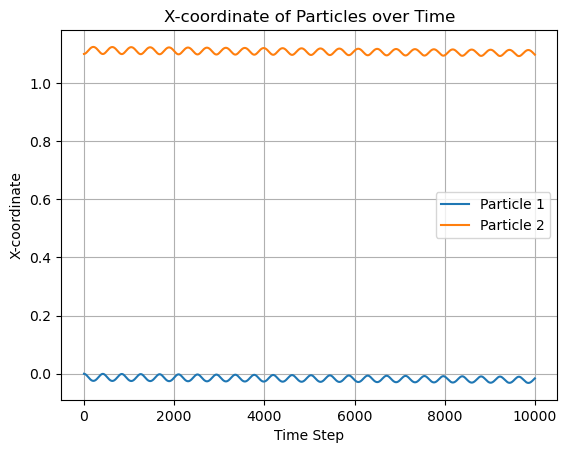

In [172]:
# Create a Simulation object
#needs to take number of simulations
simulation = Simulation(num_particles, grid_size, dt)

# Run the simulation
positions_history, _, _, _, _ = simulation.run_simulation(num_steps, custom_positions)

# Plotting
x_coords_lists = [[] for _ in range(num_particles)]

for time_step in positions_history:
    for particle_idx, particle_position in enumerate(time_step):
        x_coord = particle_position[0]  # Extract x-coordinate
        x_coords_lists[particle_idx].append(x_coord)

# Plotting
for particle_idx, x_coords in enumerate(x_coords_lists):
    plt.plot(x_coords, label=f'Particle {particle_idx + 1}')
        
plt.xlabel('Time Step')
plt.ylabel('X-coordinate')
plt.title('X-coordinate of Particles over Time')
plt.legend()
plt.grid(True)
plt.show()

TASK 2

In [181]:
#Initialsing Simulation conditions 
grid_size = 5 
dt = 0.001
num_steps = 15000
num_particles = 20

Starting a new simulation with 20 particles.
Simulation completed ;)


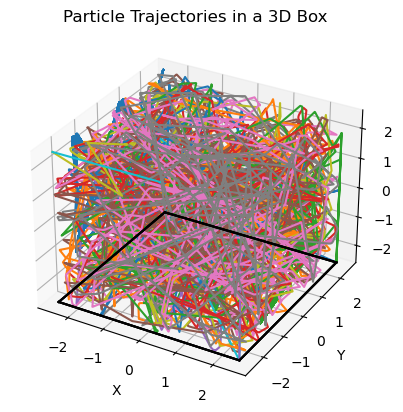

In [175]:
# Create a Simulation object
#needs to take number of simulations
simulation2 = Simulation(num_particles, grid_size, dt)

# Run the simulation
positions_history2, velocities_history2,_,_,_ = simulation2.run_simulation(num_steps)

# Plotting
x_coords_lists = [[] for _ in range(num_particles)]
y_coords_lists = [[] for _ in range(num_particles)]
z_coords_lists = [[] for _ in range(num_particles)]


# Extract x-coordinates and store them in the corresponding lists
for time_step in positions_history2:
    for particle_idx, particle_position in enumerate(time_step):
        x_coord, y_coord, z_coord = particle_position  # Extract coordinates
        x_coords_lists[particle_idx].append(x_coord)
        y_coords_lists[particle_idx].append(y_coord)
        z_coords_lists[particle_idx].append(z_coord)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
box_size = grid_size / 2
        
# Plotting particles' trajectories
for particle_idx in range(num_particles):
    ax.plot(x_coords_lists[particle_idx], y_coords_lists[particle_idx], z_coords_lists[particle_idx])

    
# Plotting box walls
box_limits = [(-box_size, box_size), (-box_size, box_size), (-box_size, box_size)]
for axis in range(3):
    lower_limit, upper_limit = box_limits[axis]
    ax.plot([lower_limit, upper_limit], [lower_limit, lower_limit], [lower_limit, lower_limit], color='k')
    ax.plot([lower_limit, upper_limit], [upper_limit, upper_limit], [lower_limit, lower_limit], color='k')
    ax.plot([lower_limit, lower_limit], [lower_limit, upper_limit], [lower_limit, lower_limit], color='k')
    ax.plot([upper_limit, upper_limit], [lower_limit, upper_limit], [lower_limit, lower_limit], color='k')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Particle Trajectories in a 3D Box')
plt.show()

TASK 3

Relationship Between Pressure and Volume

In [182]:
# Initialize constants for the simulations
dt = 0.001
num_steps = 20000
num_particles = 15
initial_grid_size = 11  

In [183]:
# Initializing empty lists for storage
pressure_list_x = []
pressure_list_y = []
pressure_list_z = []

volumes = []
isotropic = []

In [184]:
for i in range(5,11):
    current_grid_size = initial_grid_size + i
    
    volume = (current_grid_size/2)**3 # Since grid is centred at origin
    
    #Pressure store
    pressure_store = []
    
    # Initialize the Simulation object
    simulation = Simulation(num_particles, current_grid_size, dt)

    # Run the simulation
    _, _, collision_velocities_x, collision_velocities_y, collision_velocities_z = simulation.run_simulation(num_steps)

    total_time = num_steps * dt
    wall_area = (grid_size/2)**2  # Assuming a cubic box
    
    # Calculate pressure in each direction
    pressure_x = sum(abs(velocity) for velocity in collision_velocities_x) / (wall_area * total_time)
    pressure_y = sum(abs(velocity) for velocity in collision_velocities_y) / (wall_area * total_time)
    pressure_z = sum(abs(velocity) for velocity in collision_velocities_z) / (wall_area * total_time)

    # Check if pressures are approximately equal
    is_isotropic = np.isclose(pressure_x, pressure_y) and np.isclose(pressure_y, pressure_z) and np.isclose(pressure_x, pressure_z)
    isotropic.append(is_isotropic)
    
    # Track of the pressures
    pressure_list_x.append(pressure_x)
    pressure_list_y.append(pressure_y)
    pressure_list_z.append(pressure_z)

    # Track of the volume
    volumes.append(volume)

Starting a new simulation with 15 particles.
Simulation completed ;)
Starting a new simulation with 15 particles.
Simulation completed ;)
Starting a new simulation with 15 particles.
Simulation completed ;)
Starting a new simulation with 15 particles.
Simulation completed ;)
Starting a new simulation with 15 particles.
Simulation completed ;)
Starting a new simulation with 15 particles.
Simulation completed ;)


In [186]:
# Plot the pressure against volume
print(f"Is pressure isotropic?",isotropic)

Is pressure isotropic? [False, False, False, False, False, False]


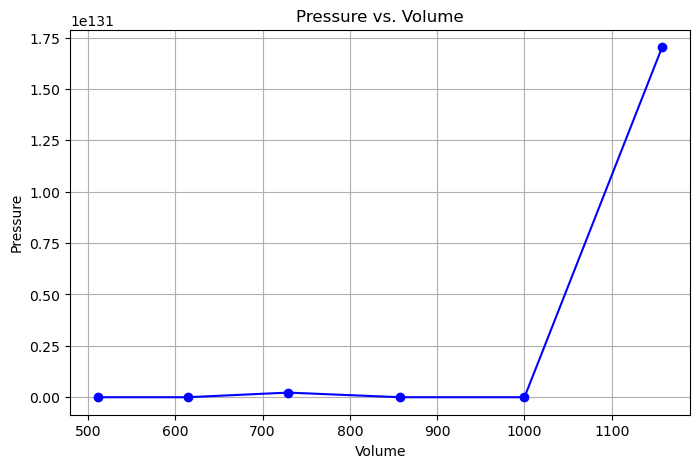

In [188]:
# Calculate the average pressure
average_pressures = np.mean([pressure_list_x, pressure_list_y, pressure_list_z], axis=0)

# Plot pressure vs volume
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
plt.plot(volumes, average_pressures, 'o-', color='blue')  # 'o-' creates a line plot with circles at the data points

plt.title('Pressure vs. Volume')
plt.xlabel('Volume')
plt.ylabel('Pressure')
plt.grid(True)  # Adds a grid to the plot
plt.show()  # Displays the plot

Relationship between temp and pressure

In [189]:
# Initialize constants for the simulations
dt = 0.001
num_steps = 2000
num_particles = 5
initial_grid_size = 6 

velocities_list = [
    np.array([2.,2.,2.]),
    np.array([4.,4.,4.]),
    np.array([6.,6.,6.]),
    np.array([8.,8.,8.]),
    np.array([10.,10.,10.])
]
 
kB = 1.38e-23 

In [190]:
# Initializing empty lists for storage
pressure_list_x = []
pressure_list_y = []
pressure_list_z = []

temps = []
isotropic = []

In [191]:
def calculate_total_kinetic_energy(velocities_history):
    total_kinetic_energy = 0.0
    for time_step in velocities_history:
        for velocity in time_step:
            kinetic_energy = 0.5 * np.linalg.norm(velocity)**2
            total_kinetic_energy += kinetic_energy
    return total_kinetic_energy

def calculate_temperature(total_kinetic_energy, num_particles, boltzmann_constant):
    temperature = (2.0 * total_kinetic_energy) / (3.0 * num_particles * boltzmann_constant)
    return temperature

In [192]:
for custom_velocities in velocities_list:
    
    #Varying initial velocites of the system
    custom_velocities
    
    
    #Pressure store
    pressure_store = []
    
    # Initialize the Simulation object
    simulation = Simulation(num_particles, current_grid_size, dt)

    # Run the simulation
    _, velocities_hist, collision_velocities_x, collision_velocities_y, collision_velocities_z = simulation.run_simulation(num_steps)

    total_time = num_steps * dt
    wall_area = (grid_size/2)**2  # Assuming a cubic box
    
    # Calculate pressure in each direction
    pressure_x = sum(abs(velocity) for velocity in collision_velocities_x) / (wall_area * total_time)
    pressure_y = sum(abs(velocity) for velocity in collision_velocities_y) / (wall_area * total_time)
    pressure_z = sum(abs(velocity) for velocity in collision_velocities_z) / (wall_area * total_time)

    # Calculate Ek
    Ek = calculate_total_kinetic_energy(velocities_hist)
    
    # Calculate Temp
    temp = calculate_temperature(Ek, num_particles, kB)
    
    # Check if pressures are approximately equal
    is_isotropic = np.isclose(pressure_x, pressure_y) and np.isclose(pressure_y, pressure_z) and np.isclose(pressure_x, pressure_z)
    isotropic.append(is_isotropic)
    
    # Track of the pressures
    pressure_list_x.append(pressure_x)
    pressure_list_y.append(pressure_y)
    pressure_list_z.append(pressure_z)

    # Track of the volume
    temps.append(temp)

Starting a new simulation with 5 particles.
Simulation completed ;)
Starting a new simulation with 5 particles.
Simulation completed ;)
Starting a new simulation with 5 particles.
Simulation completed ;)
Starting a new simulation with 5 particles.
Simulation completed ;)
Starting a new simulation with 5 particles.
Simulation completed ;)


In [195]:
temps

[4.986801314655037e+25,
 2.1113592819255248e+24,
 1.832111651772197e+23,
 1.204006384103726e+28,
 2.2578959803251263e+278]

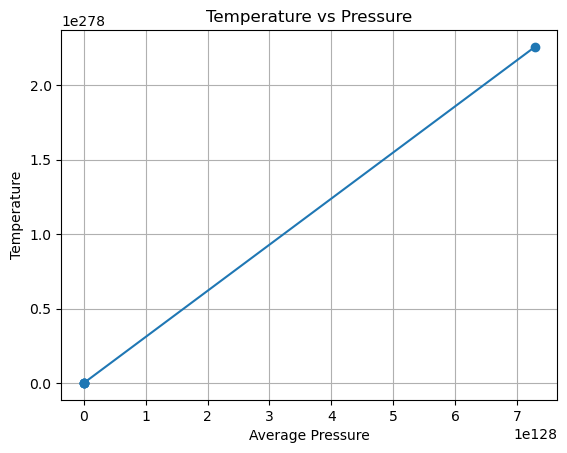

In [193]:
# Plotting temperature against pressure

# Calculate the average pressure
average_pressures = np.mean([pressure_list_x, pressure_list_y, pressure_list_z], axis=0)

plt.plot(average_pressures, temps, marker='o', linestyle='-')
plt.xlabel('Average Pressure')
plt.ylabel('Temperature')
plt.title('Temperature vs Pressure')
plt.grid(True)
plt.show()

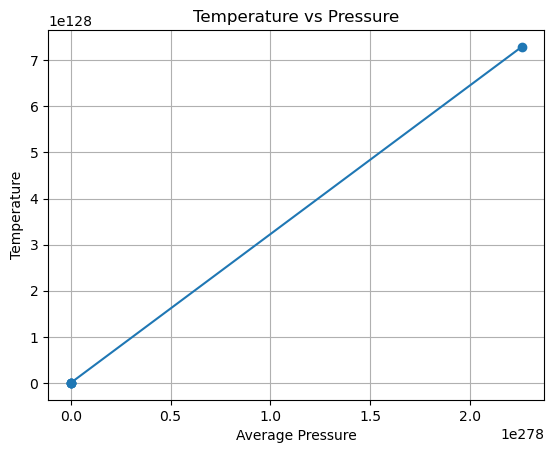

In [194]:
plt.plot(temps, average_pressures, marker='o', linestyle='-')
plt.xlabel('Average Pressure')
plt.ylabel('Temperature')
plt.title('Temperature vs Pressure')
plt.grid(True)
plt.show()